In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ast
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Loading in the data sets

In [3]:
credits_df = pd.read_csv('dataset/credits.csv')
titles_df = pd.read_csv('dataset/titles.csv')

## Credits data frame
This data frame shows the actors and directors with their respective movies and shows

In [4]:
credits_df.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


## Titles data frame
This data frame shows the attributes relating to each movie or show with their corresponding imdb scores

In [5]:
titles_df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


## Differences between the two data frames
Here we discover that some movies/shows from the titles data frame do not appear in the credits data frame.
There movies and shows will get automatically removed on merge.

In [6]:
# Remove all duplicates
credits_movie_ids = set(credits_df['id'])
titles_movie_ids = set(titles_df['id'])

# Find movie/shows ids that are in titles but not in credits
media_not_in_credits = titles_df[~titles_df['id'].isin(credits_movie_ids)]
print(len(media_not_in_credits))

361


## Group all actors and directors with their respective media
This will give us a list of all actors and directors for each movie and show

In [7]:
# Group by movie id and aggregate the data into lists
grouped_credits_df = credits_df.groupby('id').agg({
    'person_id': lambda x: list(x),
    'name': lambda x: list(x),
    'character': lambda x: list(x),
    'role': lambda x: list(x)
}).reset_index()

# Separate actors and directors into new columns
grouped_credits_df['actor'] = [[name for name, role in zip(names, roles) if role == 'ACTOR'] for names, roles in zip(grouped_credits_df['name'], grouped_credits_df['role'])]
grouped_credits_df['director'] = [[name for name, role in zip(names, roles) if role == 'DIRECTOR'] for names, roles in zip(grouped_credits_df['name'], grouped_credits_df['role'])]

# Create new columns for actor_ids and director_ids
grouped_credits_df['actor_ids'] = [[pid for pid, role in zip(pids, roles) if role == 'ACTOR'] for pids, roles in zip(grouped_credits_df['person_id'], grouped_credits_df['role'])]
grouped_credits_df['director_ids'] = [[pid for pid, role in zip(pids, roles) if role == 'DIRECTOR'] for pids, roles in zip(grouped_credits_df['person_id'], grouped_credits_df['role'])]

# Drop unnecessary columns
grouped_credits_df.drop(['name', 'role', 'person_id'], axis=1, inplace=True)
grouped_credits_df

,id,character,actor,director,actor_ids,director_ids
0,tm1000037,"[Maxi, Karl, Alex, Ante, Jitka, Pankraz, Didie...","[Luna Wedler, Jannis Niewöhner, Milan Peschel,...",[Christian Schwochow],"[251702, 41192, 589580, 191901, 237433, 76618,...",[142171]
1,tm1000147,"[David Carmichael, Jane, Marlon Veidt, Joseph ...","[Guy Pearce, Matilda Anna Ingrid Lutz, Travis ...",[Andrew Baird],"[5080, 159223, 35608, 595294, 9714, 60547, 772...",[954232]
2,tm100015,"[Gordon Jennings, John Rahway, Jack Welles, Ja...","[Idris Elba, Paul Walker, Matt Dillon, Michael...",[John Luessenhop],"[1675, 2673, 13138, 5130, 13145, 13137, 10712,...",[13150]
3,tm1000166,"[Himself, Himself, Herself, Herself, Himself, ...","[Glenn Fredly, Marcello Tahitoe, Andien Aisyah...",[Saron Sakina],"[248002, 1793972, 930514, 1794044, 1793676, 24...",[1793832]
4,tm1000185,"[Monika/Klaudia, Enzo, Ojciec Moniki, Ilona, J...","[Adrianna Chlebicka, Mateusz Banasiuk, Mirosła...",[Filip Zylber],"[1562688, 299215, 106368, 254540, 97525, 20121...",[446979]
...,...,...,...,...,...,...
5484,ts97584,"[Himself - Host, nan]",[Sebastian Perry],[William Mitchell],[1323916],[1324096]
5485,ts9794,[Self - Host],[Jerry Seinfeld],[],[32954],[]
5486,ts98252,"[Skipper (voice), Rico the Penguin (voice), Me...","[Tom McGrath, John DiMaggio, David Schwimmer, ...",[],"[9240, 1950, 9232, 22676, 5664, 8709, 916, 630...",[]
5487,ts98316,[Narrator],[John Hurt],[],[4824],[]


## Merge the two data frames into one data frame

In [8]:
# Merge titles dataframe with grouped credits dataframe
media_df = pd.merge(titles_df, grouped_credits_df, left_on = "id", right_on = "id")

media_df

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,character,actor,director,actor_ids,director_ids
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,"[Travis Bickle, Iris Steensma, Tom, Matthew 'S...","[Robert De Niro, Jodie Foster, Albert Brooks, ...",[Martin Scorsese],"[3748, 14658, 7064, 3739, 48933, 32267, 519612...",[3308]
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,"[Ed Gentry, Lewis Medlock, Bobby Trippe, Drew ...","[Jon Voight, Burt Reynolds, Ned Beatty, Ronny ...",[John Boorman],"[10103, 13020, 6639, 11224, 24509, 80069, 8403...",[17727]
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,[King Arthur / Voice of God / Middle Head / Hi...,"[Graham Chapman, John Cleese, Eric Idle, Terry...","[Terry Jones, Terry Gilliam]","[11472, 1549, 11474, 11473, 11475, 11476, 4089...","[11475, 11473]"
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,"[Maj. John Reisman, Maj. Gen. Worden, Joseph W...","[Lee Marvin, Ernest Borgnine, Charles Bronson,...",[Robert Aldrich],"[35196, 1050, 16868, 14351, 35197, 35200, 1061...",[1063]
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"['comedy', 'european']",['GB'],4.0,tt0063929,8.8,73424.0,17.617,8.306,"[Various, Various / ""It's"" man, Various, Vario...","[Graham Chapman, Michael Palin, Terry Jones, E...",[],"[11472, 11476, 11475, 11474, 11473]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,tm1216735,Sun of the Soil,MOVIE,"In 14th-century Mali, an ambitious young royal...",2022,NaN,26,[],[],NaN,NaN,NaN,NaN,1.179,7.000,[nan],[],[Joe Penney],[],[1785287]
5485,tm985215,Princess 'Daya'Reese,MOVIE,Reese is a con artist from Manila who dreams o...,2021,NaN,115,"['comedy', 'romance']",['PH'],NaN,tt13399802,7.1,50.0,1.383,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[Maymay Entrata, Edward Barber, Snooky Serna, ...",[Barry Gonzalez],"[757428, 757395, 134442, 143411, 206514, 26073...",[753271]
5486,tm1097142,My Bride,MOVIE,The story follows a young man and woman who go...,2021,NaN,93,"['romance', 'comedy', 'drama']",['EG'],NaN,tt14216488,5.0,327.0,2.545,5.300,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[Ahmed Hatem, Jamila Awad, Mahmoud Al-Bezzawy,...",[Mohamed Bakir],"[247928, 710979, 1813868, 817494, 1459769, 119...",[1827884]
5487,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,"['romance', 'drama']",['NG'],NaN,tt13857480,6.8,45.0,1.466,NaN,"[Mr. George, Kaima, Akin, Tunji, Temisan, nan,...","[Richard Mofe-Damijo, Ego Nwosu, Keppy Ekpenyo...",[Seyi Babatope],"[269015, 2151684, 361605, 1018894, 618764, 678...",[1962840]


# A look at the data structure

## Summary of all numerical attributes

In [9]:
media_df.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5489.000000,5489.000000,1840.000000,5063.000000,5.049000e+03,5487.000000,5317.000000
mean,2016.346147,78.995263,2.227717,6.503279,2.464454e+04,23.417779,6.804581
std,7.010669,38.574447,2.807934,1.155218,9.822354e+04,83.486521,1.138524
min,1954.000000,0.000000,1.000000,1.500000,5.000000e+00,0.600000,1.000000
25%,2016.000000,46.000000,1.000000,5.800000,6.080000e+02,2.902500,6.100000
50%,2018.000000,86.000000,1.000000,6.600000,2.523000e+03,7.095000,6.900000
75%,2020.000000,105.000000,2.000000,7.300000,1.055600e+04,17.262500,7.500000
max,2022.000000,240.000000,42.000000,9.500000,2.294231e+06,2274.044000,10.000000


## Description of the data so far

In [10]:
media_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5489 non-null   object 
 1   title                 5488 non-null   object 
 2   type                  5489 non-null   object 
 3   description           5481 non-null   object 
 4   release_year          5489 non-null   int64  
 5   age_certification     2990 non-null   object 
 6   runtime               5489 non-null   int64  
 7   genres                5489 non-null   object 
 8   production_countries  5489 non-null   object 
 9   seasons               1840 non-null   float64
 10  imdb_id               5120 non-null   object 
 11  imdb_score            5063 non-null   float64
 12  imdb_votes            5049 non-null   float64
 13  tmdb_popularity       5487 non-null   float64
 14  tmdb_score            5317 non-null   float64
 15  character            

## Ratings count
Here we see how many rows belong to each rating

In [11]:
media_df['imdb_score'].value_counts()

imdb_score
6.5    195
7.1    190
6.7    188
7.4    186
6.3    179
      ... 
1.5      1
9.5      1
9.2      1
1.6      1
1.7      1
Name: count, Length: 78, dtype: int64

# Start EDA

## Histogram

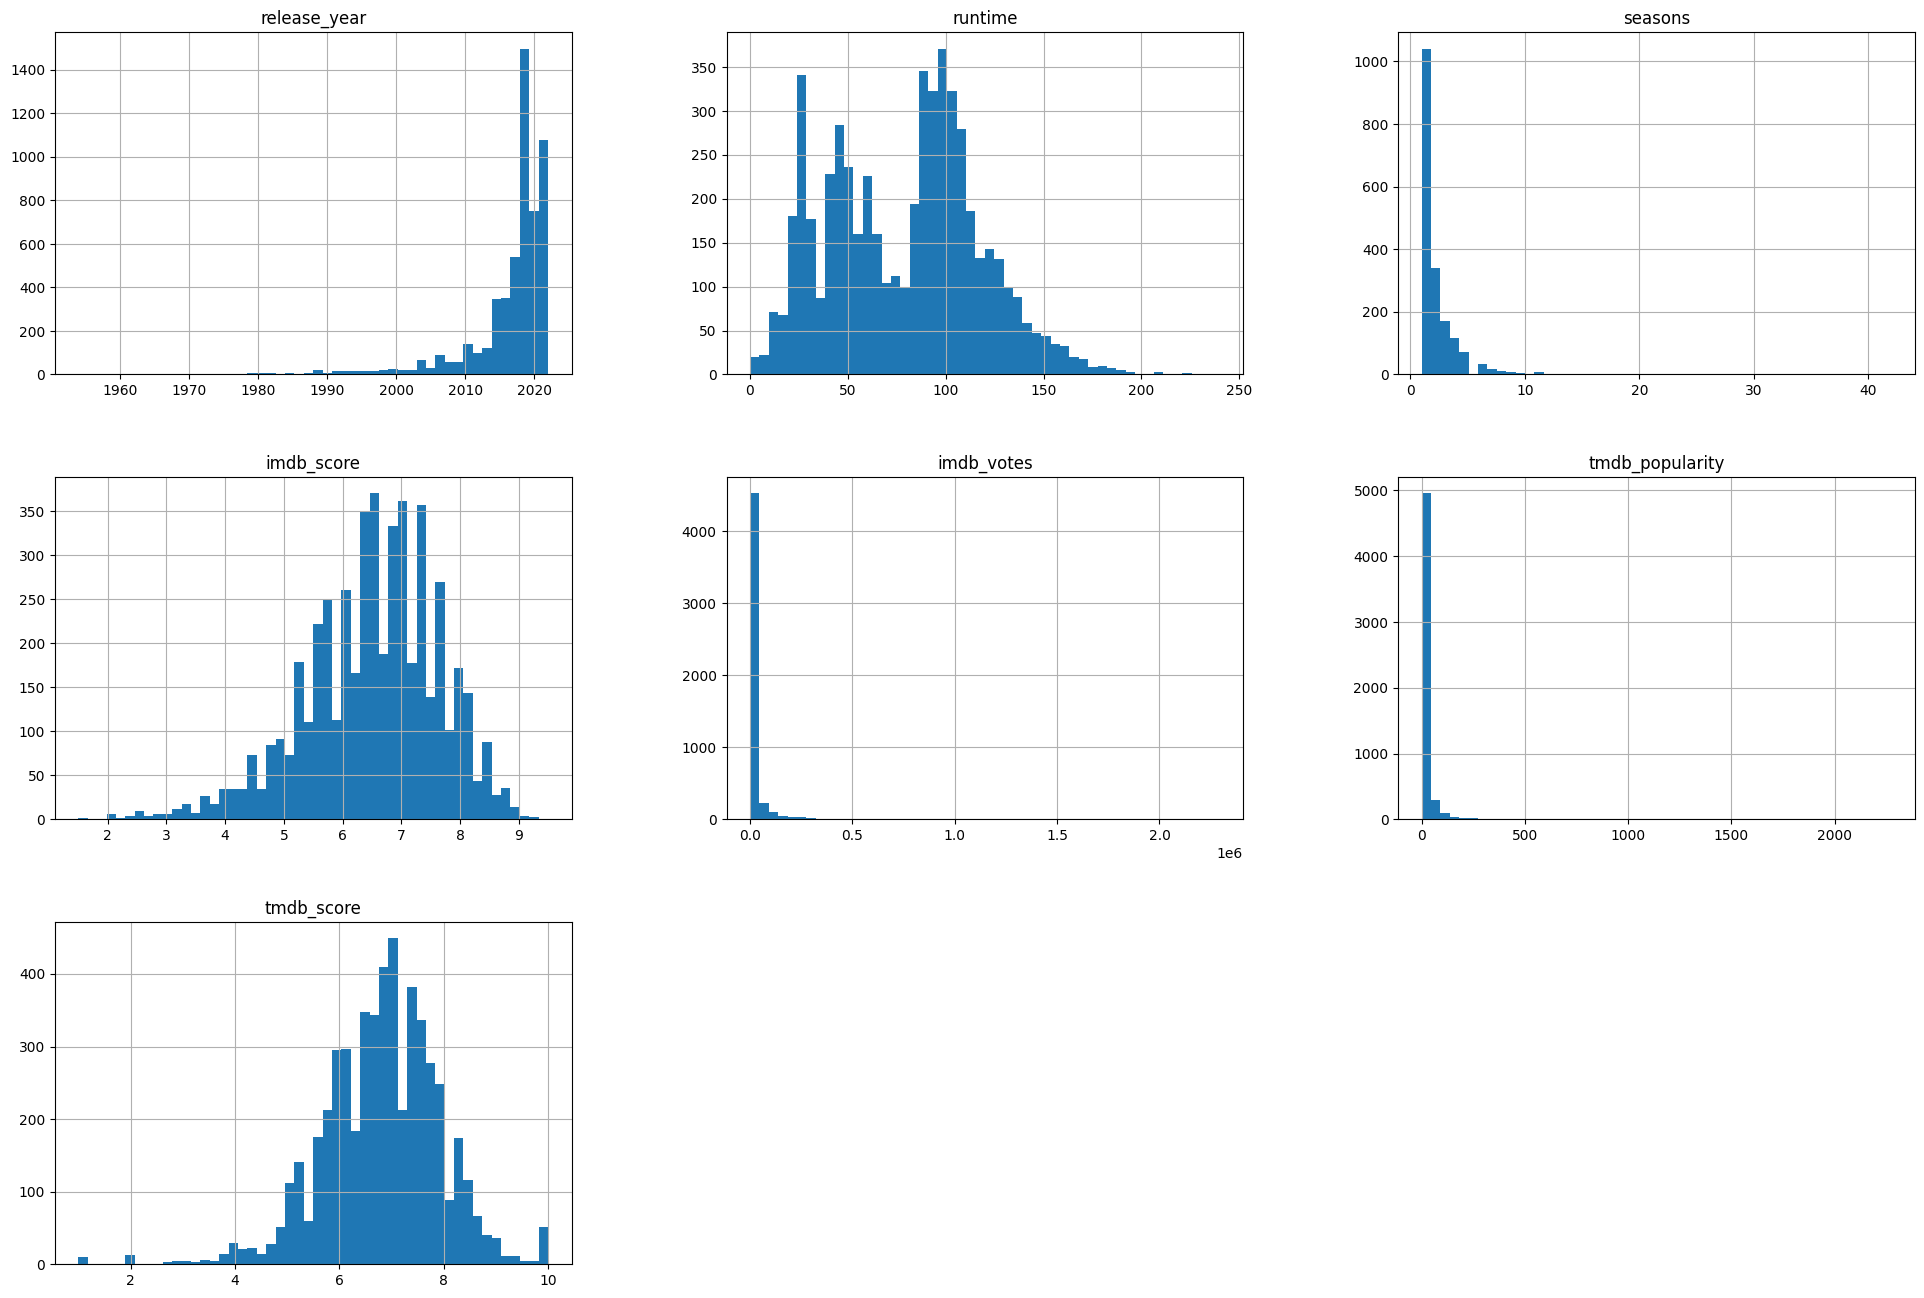

In [12]:
media_df.hist(bins=50, figsize=(24, 16))
plt.show()

## Correlations

### General correlations

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
release_year,1.000000,-0.177101,-0.535886,-0.130013,-0.208240,0.046217,0.029133
runtime,-0.177101,1.000000,-0.151898,-0.147415,0.134900,-0.007768,-0.271951
seasons,-0.535886,-0.151898,1.000000,0.104950,0.204067,0.166052,0.048226
imdb_score,-0.130013,-0.147415,0.104950,1.000000,0.197259,0.018180,0.587753
imdb_votes,-0.208240,0.134900,0.204067,0.197259,1.000000,0.207808,0.121751
tmdb_popularity,0.046217,-0.007768,0.166052,0.018180,0.207808,1.000000,0.079296
tmdb_score,0.029133,-0.271951,0.048226,0.587753,0.121751,0.079296,1.000000


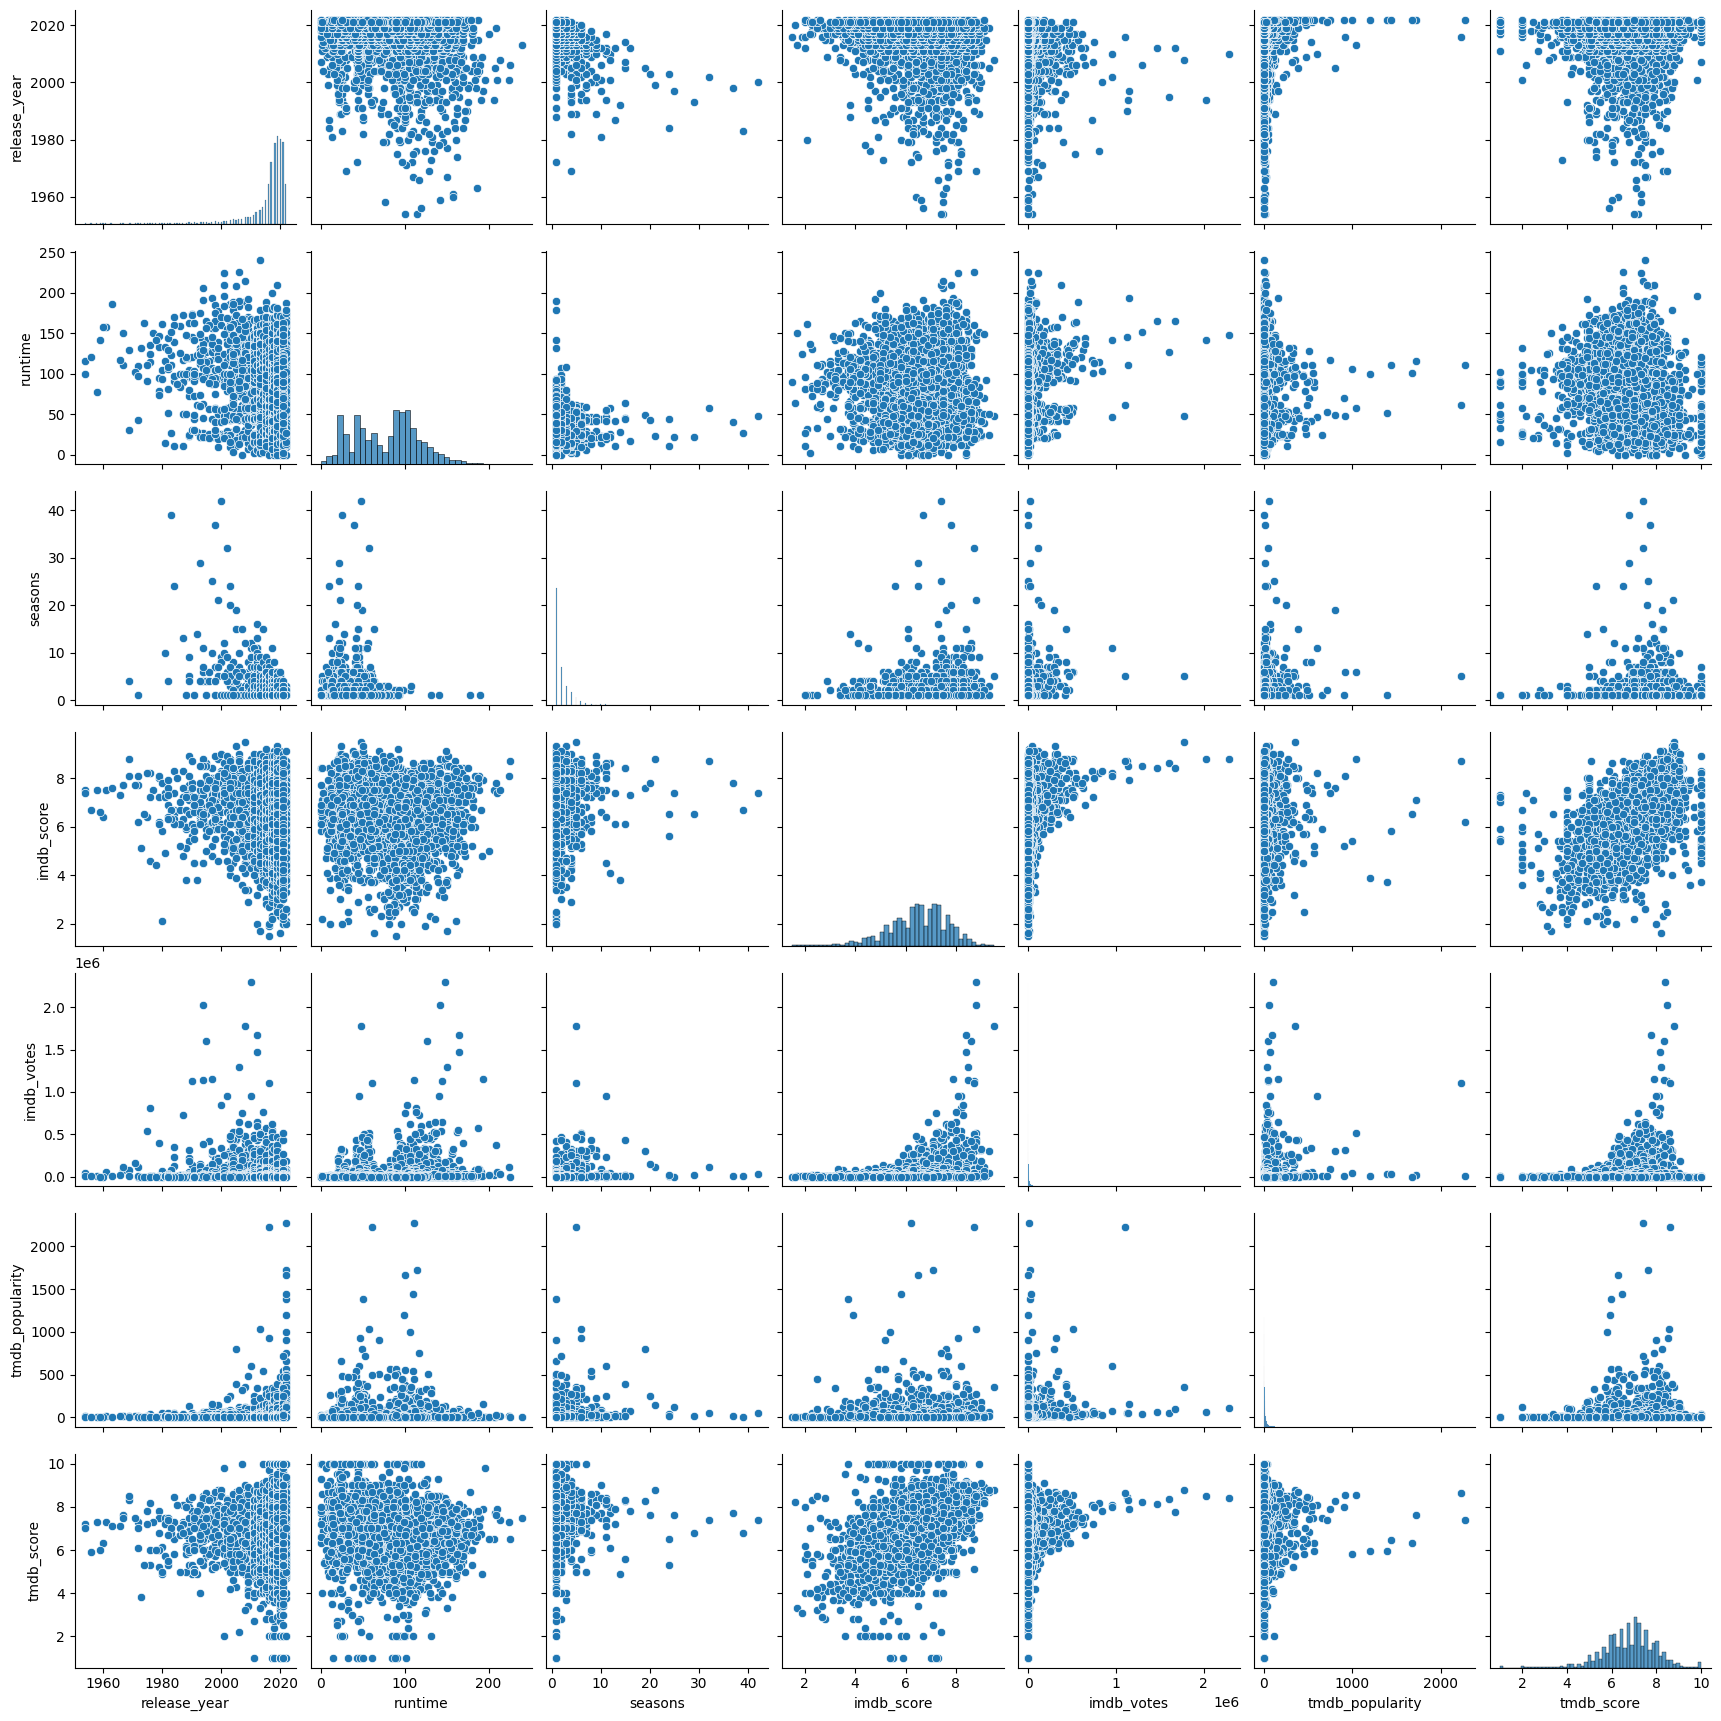

In [13]:
sns.pairplot(media_df)
corr_matrix = media_df.corr(numeric_only=True)
corr_matrix

### Correlations with imdb

In [14]:
corr_matrix['imdb_score'].sort_values(ascending=False)

imdb_score         1.000000
tmdb_score         0.587753
imdb_votes         0.197259
seasons            0.104950
tmdb_popularity    0.018180
release_year      -0.130013
runtime           -0.147415
Name: imdb_score, dtype: float64

## Line graph showing correlation of imdb_score vs tmdb_score

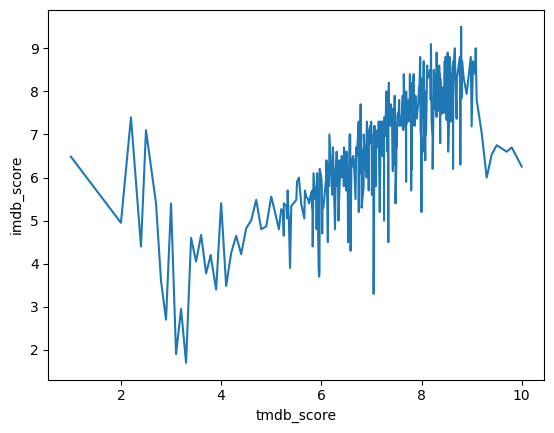

In [15]:
g = sns.lineplot(x="tmdb_score", y="imdb_score", data=media_df, errorbar=None)

## Line graph showing the imdb_score vs tmdb_score over time

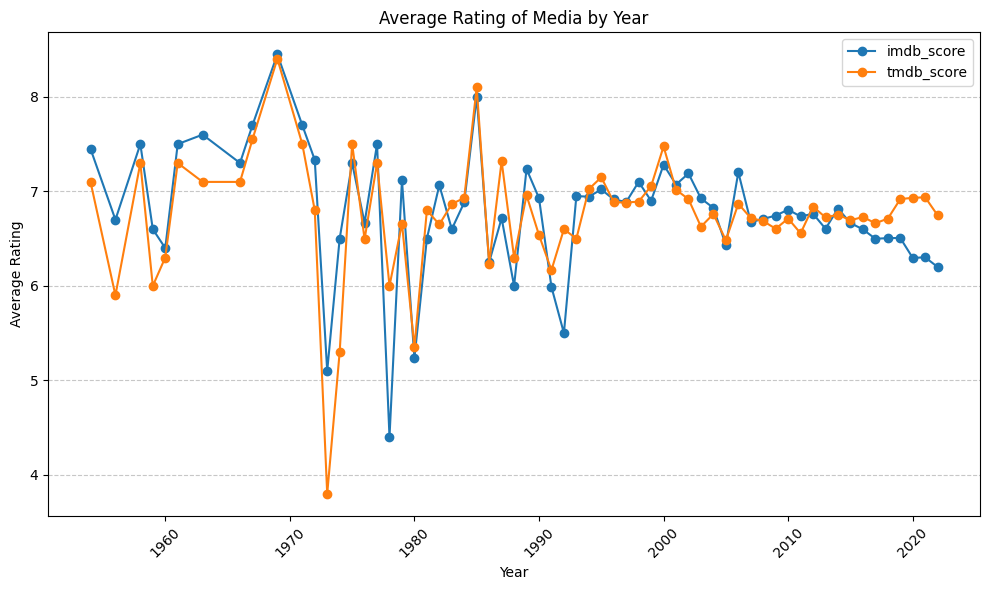

In [16]:
# Rating of movies and shows over time
score_columns = ['imdb_score','tmdb_score']
avg_media_ratings = media_df.groupby('release_year')[score_columns].mean()

def plot_avg_rating_by_year(avg_ratings):
    plt.figure(figsize=(10, 6))
    
    for column in score_columns:
        plt.plot(avg_ratings.index, avg_ratings[column], marker='o', linestyle='-', label=column)
    
    # Plot line graphs
    plt.title('Average Rating of Media by Year')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_avg_rating_by_year(avg_media_ratings)

## Line graph showing correlation of imdb_score vs imdb_votes

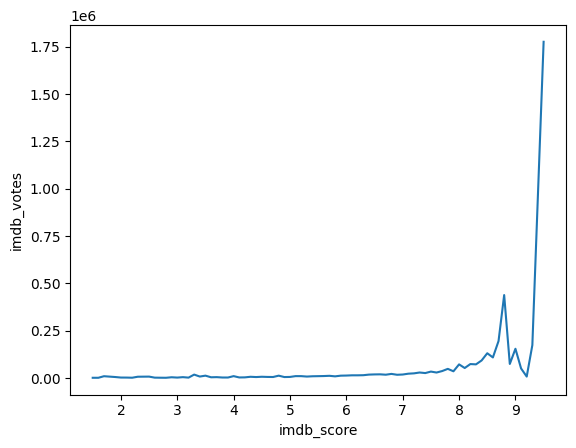

In [17]:
g = sns.lineplot(x="imdb_score", y="imdb_votes", data=media_df, errorbar=None)

## Scatter plot showing correlation of imdb_score vs imdb_votes

Text(0, 0.5, 'imdb_votes')

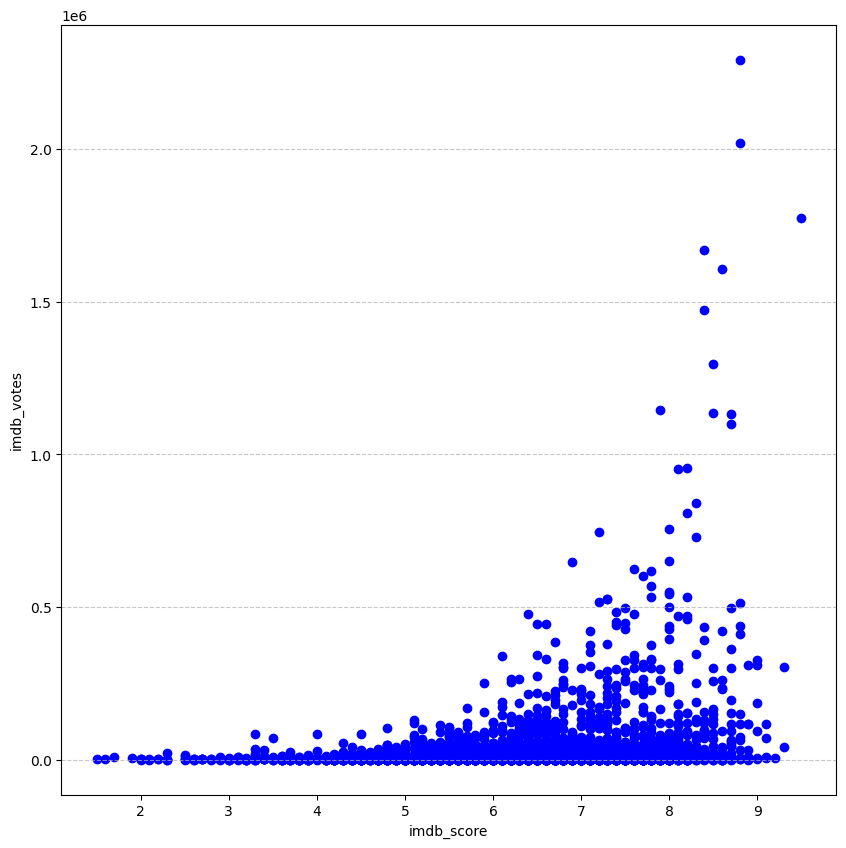

In [18]:
X = media_df["imdb_score"]
y = media_df["imdb_votes"]

fig, pl = plt.subplots(figsize=(10, 10))
pl.scatter(X, y, color = 'b')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("imdb_score")
plt.ylabel("imdb_votes")

## Correlation between imdb_score, genre average imdb score and filmmakers average cumulative media imdb scores

### Here we add two new columns that refer to the cumulative average imdb scores of the actors and directors for each piece of media as well as hot encoding the genres and adding an average genre score

In [19]:
# Merge titles dataframe with credits dataframe
combined_df = pd.merge(titles_df, credits_df, left_on = "id", right_on = "id")

actor_df=combined_df[combined_df['role']=='ACTOR']
director_df=combined_df[combined_df['role']=='DIRECTOR']

# Calculate average scores for actors and directors
actors_avg_scores = actor_df.groupby('person_id')['imdb_score'].mean().reset_index()
directors_avg_scores = director_df.groupby('person_id')['imdb_score'].mean().reset_index()

# Function to calculate cumulative average score
def calculate_cumulative_avg(person_ids, avg_scores_df):
    scores = avg_scores_df[avg_scores_df['person_id'].isin(person_ids)]['imdb_score']

    if len(scores) == 0:
        return None
    return scores.mean()

# Apply the function to each row in 'media_df' and create new columns
media_df['cumulative_avg_actor_score'] = media_df['actor_ids'].apply(lambda x: calculate_cumulative_avg(x, actors_avg_scores))
media_df['cumulative_avg_director_score'] = media_df['director_ids'].apply(lambda x: calculate_cumulative_avg(x, directors_avg_scores))

media_df

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,...,imdb_votes,tmdb_popularity,tmdb_score,character,actor,director,actor_ids,director_ids,cumulative_avg_actor_score,cumulative_avg_director_score
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,...,808582.0,40.965,8.179,"[Travis Bickle, Iris Steensma, Tom, Matthew 'S...","[Robert De Niro, Jodie Foster, Albert Brooks, ...",[Martin Scorsese],"[3748, 14658, 7064, 3739, 48933, 32267, 519612...",[3308],7.983333,8.16
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,...,107673.0,10.010,7.300,"[Ed Gentry, Lewis Medlock, Bobby Trippe, Drew ...","[Jon Voight, Burt Reynolds, Ned Beatty, Ronny ...",[John Boorman],"[10103, 13020, 6639, 11224, 24509, 80069, 8403...",[17727],7.521970,7.70
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,...,534486.0,15.461,7.811,[King Arthur / Voice of God / Middle Head / Hi...,"[Graham Chapman, John Cleese, Eric Idle, Terry...","[Terry Jones, Terry Gilliam]","[11472, 1549, 11474, 11473, 11475, 11476, 4089...","[11475, 11473]",8.142933,8.15
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,...,72662.0,20.398,7.600,"[Maj. John Reisman, Maj. Gen. Worden, Joseph W...","[Lee Marvin, Ernest Borgnine, Charles Bronson,...",[Robert Aldrich],"[35196, 1050, 16868, 14351, 35197, 35200, 1061...",[1063],7.686111,7.70
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,"['comedy', 'european']",['GB'],4.0,...,73424.0,17.617,8.306,"[Various, Various / ""It's"" man, Various, Vario...","[Graham Chapman, Michael Palin, Terry Jones, E...",[],"[11472, 11476, 11475, 11474, 11473]",[],7.952042,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,tm1216735,Sun of the Soil,MOVIE,"In 14th-century Mali, an ambitious young royal...",2022,NaN,26,[],[],NaN,...,NaN,1.179,7.000,[nan],[],[Joe Penney],[],[1785287],NaN,NaN
5485,tm985215,Princess 'Daya'Reese,MOVIE,Reese is a con artist from Manila who dreams o...,2021,NaN,115,"['comedy', 'romance']",['PH'],NaN,...,50.0,1.383,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[Maymay Entrata, Edward Barber, Snooky Serna, ...",[Barry Gonzalez],"[757428, 757395, 134442, 143411, 206514, 26073...",[753271],6.731270,4.80
5486,tm1097142,My Bride,MOVIE,The story follows a young man and woman who go...,2021,NaN,93,"['romance', 'comedy', 'drama']",['EG'],NaN,...,327.0,2.545,5.300,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[Ahmed Hatem, Jamila Awad, Mahmoud Al-Bezzawy,...",[Mohamed Bakir],"[247928, 710979, 1813868, 817494, 1459769, 119...",[1827884],5.068889,5.00
5487,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,"['romance', 'drama']",['NG'],NaN,...,45.0,1.466,NaN,"[Mr. George, Kaima, Akin, Tunji, Temisan, nan,...","[Richard Mofe-Damijo, Ego Nwosu, Keppy Ekpenyo...",[Seyi Babatope],"[269015, 2151684, 361605, 1018894, 618764, 678...",[1962840],6.035909,5.05


## Hot encoded Genres

In [20]:
# Initialize an empty list to store all genres
genres_list = []

# Use ast.literal_eval to store all genres into a list
for x in media_df['genres']:
    y = ast.literal_eval(x)
    genres_list.extend(y)

# Remove duplicates
genres_set = list(set(genres_list))

# Create a DataFrame of genres with binary values (0 or 1)
genres_df = media_df['genres'].apply(lambda x: pd.Series([1 if genre in ast.literal_eval(x) else 0 for genre in genres_set], index=genres_set))

# Concatenate the new DataFrame with the original one
media_df = pd.concat([media_df, genres_df], axis=1)

# Drop NaN values in 'imdb_score' column
media_df = media_df.dropna(subset=['imdb_score'])

# Drop the 'genres' column
media_df = media_df.drop('genres', axis=1)

# Drop duplicates based on the 'id' column
media_df = media_df.drop_duplicates(subset='id')
media_df.reset_index(drop=True, inplace=True)

media_df

,id,title,type,description,release_year,age_certification,runtime,production_countries,seasons,imdb_id,...,animation,music,reality,fantasy,thriller,crime,comedy,war,scifi,western
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,['US'],NaN,tt0075314,...,0,0,0,0,0,1,0,0,0,0
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,['US'],NaN,tt0068473,...,0,0,0,0,1,0,0,0,0,0
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,['GB'],NaN,tt0071853,...,0,0,0,1,0,0,1,0,0,0
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['GB', 'US']",NaN,tt0061578,...,0,0,0,0,0,0,0,1,0,0
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,['GB'],4.0,tt0063929,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,tm1165179,Kongsi Raya,MOVIE,Jack - a Chinese chef-manager who is in-line t...,2022,NaN,102,['MY'],NaN,tt16806990,...,0,0,0,0,0,0,1,0,0,0
5059,tm985215,Princess 'Daya'Reese,MOVIE,Reese is a con artist from Manila who dreams o...,2021,NaN,115,['PH'],NaN,tt13399802,...,0,0,0,0,0,0,1,0,0,0
5060,tm1097142,My Bride,MOVIE,The story follows a young man and woman who go...,2021,NaN,93,['EG'],NaN,tt14216488,...,0,0,0,0,0,0,1,0,0,0
5061,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,['NG'],NaN,tt13857480,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Calculate the average IMDb score for each genre
average_scores_by_genre = {}
for genre in genres_set:
    genre_columns = [col for col in media_df.columns if genre in col]
    average_scores_by_genre[genre] = media_df[media_df[genre_columns].any(axis=1)]['imdb_score'].mean()

# Convert the result into a DataFrame
average_scores_df = pd.DataFrame(list(average_scores_by_genre.items()), columns=['Genre', 'Average IMDb Score'])

# Sort genres by average score in descending order
average_scores_df = average_scores_df.sort_values(by='Average IMDb Score', ascending=False)

In [22]:
media_df['cumulative_imdb'] = 0

# Lowercase the genre names in media_df columns
media_df.columns = [col.lower() for col in media_df.columns]
#iterate through rows
for index, row in media_df.iterrows():
    score = 0
    numCount = 0
    #iterate through the new columns that were hot encoded
    for genre in media_df.columns[20:]:
        #find the mean for that genre and add it to its average imdb score
        if row[genre] == 1:
            numCount += 1
            genre_name = genre.split('_')[-1].lower()  # Extract genre name and lowercase
            if genre_name in average_scores_df['Genre'].str.lower().values:
                score += average_scores_df.loc[average_scores_df['Genre'].str.lower() == genre_name, 'Average IMDb Score'].values[0]
    
    if numCount > 0:
        score /= numCount

    media_df.at[index, 'cumulative_imdb'] = score

media_df

C:\Users\chapl\AppData\Local\Temp\ipykernel_8496\3932194621.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.635201686699312' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  media_df.at[index, 'cumulative_imdb'] = score


,id,title,type,description,release_year,age_certification,runtime,production_countries,seasons,imdb_id,...,music,reality,fantasy,thriller,crime,comedy,war,scifi,western,cumulative_imdb
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,['US'],NaN,tt0075314,...,0,0,0,0,1,0,0,0,0,6.635202
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,['US'],NaN,tt0068473,...,0,0,0,1,0,0,0,0,0,6.480488
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,['GB'],NaN,tt0071853,...,0,0,1,0,0,1,0,0,0,6.455812
3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['GB', 'US']",NaN,tt0061578,...,0,0,0,0,0,0,1,0,0,6.741455
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,['GB'],4.0,tt0063929,...,0,0,0,0,0,1,0,0,0,6.447009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,tm1165179,Kongsi Raya,MOVIE,Jack - a Chinese chef-manager who is in-line t...,2022,NaN,102,['MY'],NaN,tt16806990,...,0,0,0,0,0,1,0,0,0,6.386289
5059,tm985215,Princess 'Daya'Reese,MOVIE,Reese is a con artist from Manila who dreams o...,2021,NaN,115,['PH'],NaN,tt13399802,...,0,0,0,0,0,1,0,0,0,6.384078
5060,tm1097142,My Bride,MOVIE,The story follows a young man and woman who go...,2021,NaN,93,['EG'],NaN,tt14216488,...,0,0,0,0,0,1,0,0,0,6.464579
5061,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,['NG'],NaN,tt13857480,...,0,0,0,0,0,0,0,0,0,6.503723


,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,cumulative_avg_actor_score,cumulative_avg_director_score,cumulative_imdb
release_year,1.000000,-0.174982,-0.544327,-0.130013,-0.208240,0.046203,0.029824,-0.136333,-0.115306,0.029175
runtime,-0.174982,1.000000,-0.150983,-0.147415,0.134900,-0.013469,-0.294567,-0.124678,-0.050827,-0.015320
seasons,-0.544327,-0.150983,1.000000,0.104950,0.204067,0.165432,0.052666,0.063288,-0.035156,-0.074391
imdb_score,-0.130013,-0.147415,0.104950,1.000000,0.197259,0.018180,0.587753,0.940292,0.933886,0.222583
imdb_votes,-0.208240,0.134900,0.204067,0.197259,1.000000,0.207808,0.121751,0.180997,0.166000,-0.031504
tmdb_popularity,0.046203,-0.013469,0.165432,0.018180,0.207808,1.000000,0.084753,0.010791,-0.039750,-0.056692
tmdb_score,0.029824,-0.294567,0.052666,0.587753,0.121751,0.084753,1.000000,0.553283,0.589467,0.127670
cumulative_avg_actor_score,-0.136333,-0.124678,0.063288,0.940292,0.180997,0.010791,0.553283,1.000000,0.910512,0.234532
cumulative_avg_director_score,-0.115306,-0.050827,-0.035156,0.933886,0.166000,-0.039750,0.589467,0.910512,1.000000,0.327125
cumulative_imdb,0.029175,-0.015320,-0.074391,0.222583,-0.031504,-0.056692,0.127670,0.234532,0.327125,1.000000


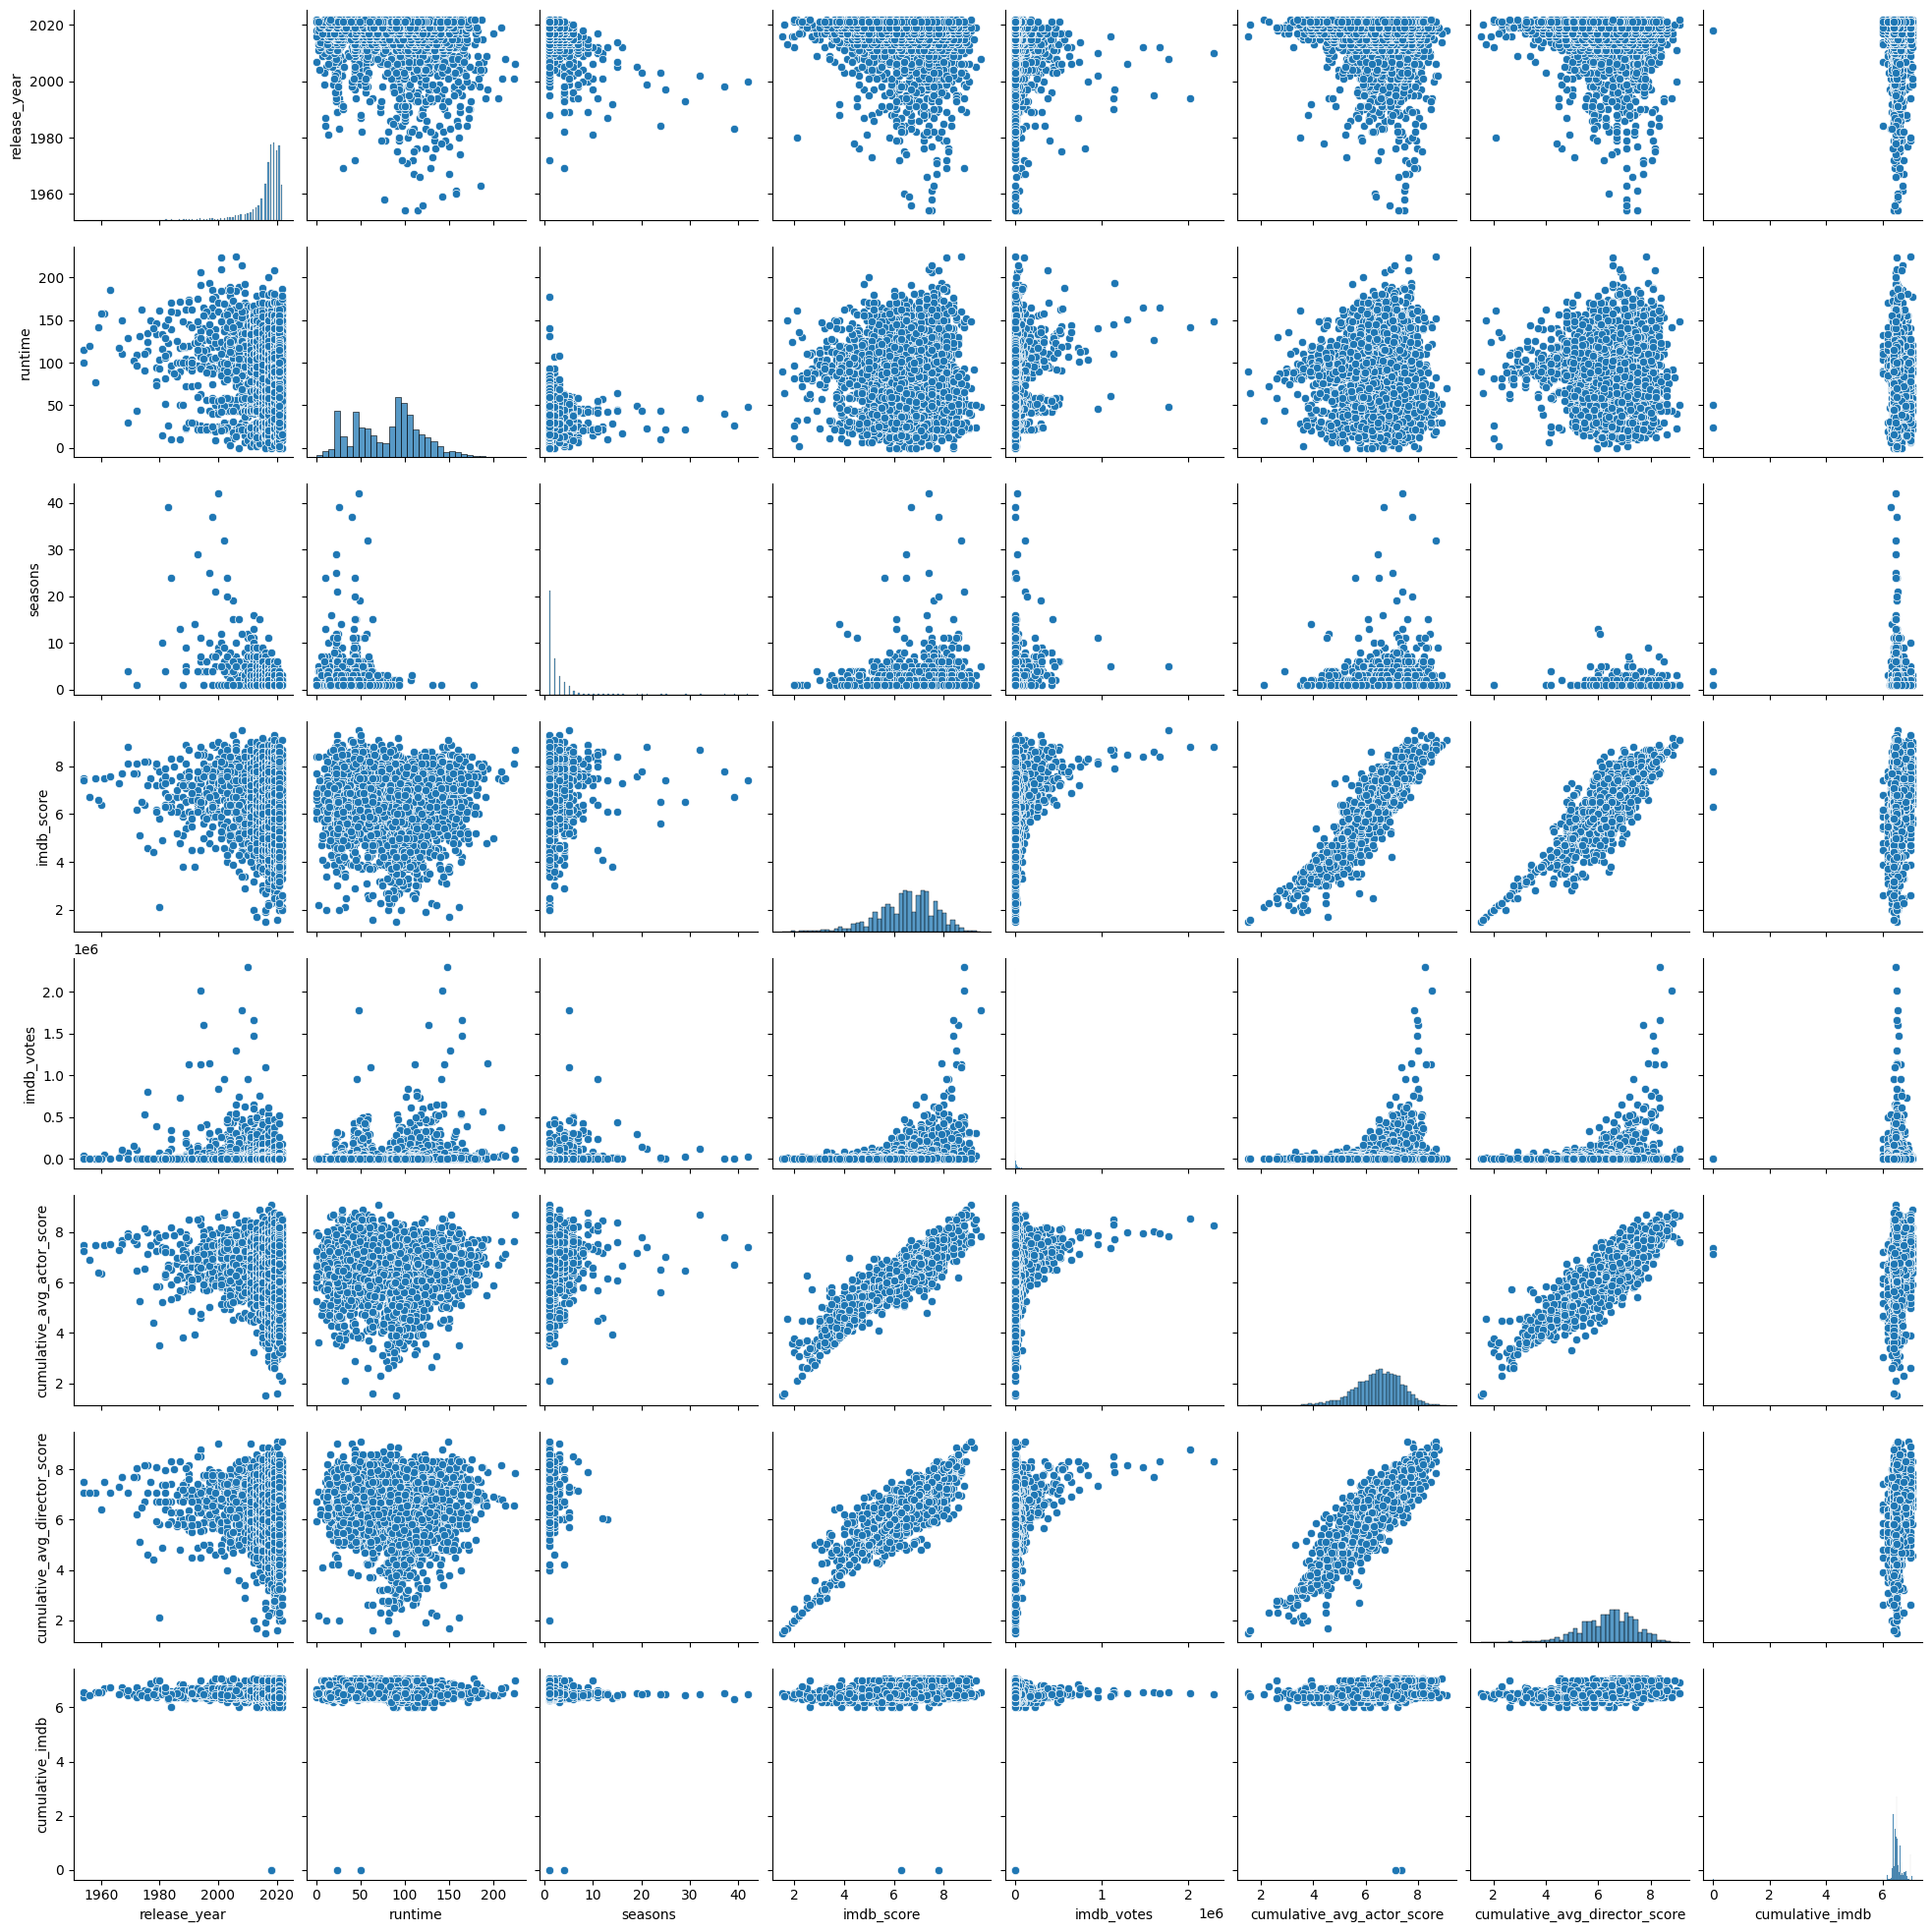

In [23]:
#list of columns we want to include in the EDAs and correlation
media_include=['release_year', 'age_certification', 'runtime', 'seasons', 'imdb_score',
       'imdb_votes', 'cumulative_avg_actor_score',
       'cumulative_avg_director_score', 'cumulative_imdb']
media_subset=media_df[media_include]
sns.pairplot(media_subset)
#list we want to exlude from the EDAs and correlation
columns_to_exclude = ['crime', 'history', 'drama', 'fantasy',
       'documentation', 'animation', 'reality', 'music', 'comedy', 'scifi',
       'war', 'horror', 'family', 'western', 'romance', 'thriller', 'sport',
       'european', 'action']
#creating correlation matrix
corr_matrix_new = media_df.corr(numeric_only=True)
corr_matrix_new = corr_matrix_new.drop(columns=columns_to_exclude, index=columns_to_exclude)
corr_matrix_new

# Data Cleaning

Remove all unnecessary data based on correlations gathered from previous observations and prepare the data for preprocessing.

In [24]:
# Data cleaning
media_df = media_df.drop(columns=['imdb_id','tmdb_popularity','tmdb_score','character'], axis=1)
media_df.dropna(subset=['title','imdb_score','imdb_votes'], inplace=True)
media_df['seasons']=media_df['seasons'].fillna(0)

media_df.reset_index()

,index,id,title,type,description,release_year,age_certification,runtime,production_countries,seasons,...,music,reality,fantasy,thriller,crime,comedy,war,scifi,western,cumulative_imdb
0,0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,['US'],0.0,...,0,0,0,0,1,0,0,0,0,6.635202
1,1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,['US'],0.0,...,0,0,0,1,0,0,0,0,0,6.480488
2,2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,['GB'],0.0,...,0,0,1,0,0,1,0,0,0,6.455812
3,3,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['GB', 'US']",0.0,...,0,0,0,0,0,0,1,0,0,6.741455
4,4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,['GB'],4.0,...,0,0,0,0,0,1,0,0,0,6.447009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5044,5058,tm1165179,Kongsi Raya,MOVIE,Jack - a Chinese chef-manager who is in-line t...,2022,NaN,102,['MY'],0.0,...,0,0,0,0,0,1,0,0,0,6.386289
5045,5059,tm985215,Princess 'Daya'Reese,MOVIE,Reese is a con artist from Manila who dreams o...,2021,NaN,115,['PH'],0.0,...,0,0,0,0,0,1,0,0,0,6.384078
5046,5060,tm1097142,My Bride,MOVIE,The story follows a young man and woman who go...,2021,NaN,93,['EG'],0.0,...,0,0,0,0,0,1,0,0,0,6.464579
5047,5061,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,NaN,100,['NG'],0.0,...,0,0,0,0,0,0,0,0,0,6.503723


In [25]:
#removing all rows that arents being used to predict the outcome
media_df=media_df.drop(columns='actor')
media_df=media_df.drop(columns='actor_ids')
media_df=media_df.drop(columns='director')
media_df=media_df.drop(columns='director_ids')
media_df=media_df.drop(columns='production_countries')
media_df=media_df.drop(columns='description')
media_df=media_df.drop(columns='title')
media_df=media_df.drop(columns='type')
media_df=media_df.drop(columns='id')
media_df

,release_year,age_certification,runtime,seasons,imdb_score,imdb_votes,cumulative_avg_actor_score,cumulative_avg_director_score,action,european,...,music,reality,fantasy,thriller,crime,comedy,war,scifi,western,cumulative_imdb
0,1976,R,114,0.0,8.2,808582.0,7.983333,8.16,0,0,...,0,0,0,0,1,0,0,0,0,6.635202
1,1972,R,109,0.0,7.7,107673.0,7.521970,7.70,1,1,...,0,0,0,1,0,0,0,0,0,6.480488
2,1975,PG,91,0.0,8.2,534486.0,8.142933,8.15,1,0,...,0,0,1,0,0,1,0,0,0,6.455812
3,1967,NaN,150,0.0,7.7,72662.0,7.686111,7.70,1,0,...,0,0,0,0,0,0,1,0,0,6.741455
4,1969,TV-14,30,4.0,8.8,73424.0,7.952042,NaN,0,1,...,0,0,0,0,0,1,0,0,0,6.447009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,2022,NaN,102,0.0,7.0,66.0,6.645833,6.55,0,0,...,0,0,0,0,0,1,0,0,0,6.386289
5059,2021,NaN,115,0.0,7.1,50.0,6.731270,4.80,0,0,...,0,0,0,0,0,1,0,0,0,6.384078
5060,2021,NaN,93,0.0,5.0,327.0,5.068889,5.00,0,0,...,0,0,0,0,0,1,0,0,0,6.464579
5061,2021,NaN,100,0.0,6.8,45.0,6.035909,5.05,0,0,...,0,0,0,0,0,0,0,0,0,6.503723


In [26]:
media_df=media_df.dropna()

In [27]:

# create the cat and num columns
num_cols = media_df.select_dtypes(include='number').columns.to_list()
cat_cols = media_df.select_dtypes(exclude='number').columns.to_list()


#exclude the target from numerical columns
num_cols.remove("imdb_score")

#create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

#use ColumnTransformer to set the estimators and transformations


preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

In [28]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['release_year', 'runtime', 'seasons',
                                  'imdb_votes', 'cumulative_avg_actor_score',
                                  'cumulative_avg_director_score', 'action',
                                  'european', 'drama', 'family', 'history',
                                  'documentation', 'sport', 'romance', 'horror',
                                  'animation', 'music', 'reality', 'fantasy',
                                  'thriller', 'crime', 'comedy', 'war', 'scifi',
                                  'western', 'cumulative_imdb']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['age_certification'])])

## Applying the preprocessing

In [29]:
# Apply the preprocessing pipeline on the dataset
media_prepared = preprocessing.fit_transform(media_df)

# Scikit-learn strips the column headers in most cases, so just add them back on afterward.
feature_names=preprocessing.get_feature_names_out()
media_prepared = pd.DataFrame(data=media_prepared, columns=feature_names)
 
media_prepared

,num__release_year,num__runtime,num__seasons,num__imdb_votes,num__cumulative_avg_actor_score,num__cumulative_avg_director_score,num__action,num__european,num__drama,num__family,...,cat__age_certification_PG,cat__age_certification_PG-13,cat__age_certification_R,cat__age_certification_TV-14,cat__age_certification_TV-G,cat__age_certification_TV-MA,cat__age_certification_TV-PG,cat__age_certification_TV-Y,cat__age_certification_TV-Y7,remainder__imdb_score
0,-5.081675,0.588859,-0.403805,5.027985,1.634302,1.574724,-0.595798,-0.287896,0.813536,-0.36727,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.2
1,-5.602365,0.447231,-0.403805,0.373225,1.114633,1.132149,1.678423,3.473477,0.813536,-0.36727,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.7
2,-5.211847,-0.062626,-0.403805,3.207704,1.814071,1.565102,1.678423,-0.287896,-1.229202,-0.36727,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.2
3,-4.691157,0.022350,-0.403805,2.281532,1.582381,1.516996,-0.595798,-0.287896,-1.229202,-0.36727,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,-5.732538,0.248954,-0.403805,0.687864,1.294084,1.132149,1.678423,-0.287896,-1.229202,-0.36727,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,0.906267,-0.997365,-0.403805,-0.339325,-0.487036,-0.407240,-0.595798,-0.287896,0.813536,-0.36727,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.1
1603,0.776095,0.560533,-0.403805,-0.340095,-1.275498,0.394525,-0.595798,-0.287896,-1.229202,-0.36727,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4
1604,0.776095,0.079001,-0.403805,-0.272005,-0.456821,-0.503451,-0.595798,-0.287896,0.813536,-0.36727,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1605,0.776095,-1.252294,0.866087,-0.326255,1.847630,1.709420,-0.595798,-0.287896,0.813536,-0.36727,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.3


In [30]:
# from sklearn.preprocessing import MultiLabelBinarizer

# # Extract numerical and categorical columns
# num_cols = media_df.select_dtypes(include='number').columns.to_list()
# cat_cols = media_df.select_dtypes(exclude='number').columns.to_list()

# # Remove target column from numerical columns
# num_cols.remove("imdb_score")

# # Create pipelines for numerical and categorical columns
# num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

# # Fit MultiLabelBinarizer on concatenated lists of categories
# mlb = MultiLabelBinarizer()
# cat_data = mlb.fit_transform(media_df['genres'])

# # Get the list of encoded categories
# cat_cols_encoded = mlb.classes_

# # Use ColumnTransformer to set the estimators and transformations
# preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
#                                    ('cat', 'passthrough', slice(len(num_cols), len(num_cols) + cat_data.shape[1]))],
#                                   remainder='passthrough')

# # Apply the preprocessing pipeline on the dataset
# media_prepared = preprocessing.fit_transform(media_df)

# # Concatenate encoded categorical columns with numerical and remaining columns
# feature_names = num_cols + list(cat_cols_encoded) + ['other_columns']
# media_prepared = pd.DataFrame(data=media_prepared, columns=feature_names)

## Split the data into testing and training sets

In [31]:
X = media_prepared.drop("remainder__imdb_score", axis=1)
y = media_prepared['remainder__imdb_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1285, 37) (1285,) (322, 37) (322,)


## AI ALgorithms

In [32]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

lr_model.fit(X_train,y_train)

LinearRegression()

In [33]:

lr_y_predict = lr_model.predict(X_test)

from sklearn.metrics import mean_squared_error as mse
lr_mse=mse(y_test, lr_y_predict)
lr_mse

0.07114799252599043

In [34]:
from sklearn.model_selection import cross_val_score, KFold

scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

scores

array([-0.10134785, -0.11367159, -0.0782691 , -0.08353428, -0.09083498])

In [35]:
mean_score = -scores.mean()  # Take the negative value to get the mean squared error

print(f'Cross-Validation Mean Score: {mean_score}')

Cross-Validation Mean Score: 0.09353155948903244


In [36]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

RidgeRegression = Ridge(alpha=1)
ridge_model = RidgeRegression.fit(X_train, y_train)


LassoRegression = Lasso(alpha=1)
lasso_model = LassoRegression.fit(X_train, y_train)
Ridge_y_predict = ridge_model.predict(X_test)
Lasso_y_predict = lasso_model.predict(X_test)
ridge_mse = mse(y_test, Ridge_y_predict)
lasso_mse=mse(y_test, Lasso_y_predict)

print(f'Ridge Regression MSE: {ridge_mse}')
print(f'Lasso Regression MSE: {lasso_mse}')

Ridge Regression MSE: 0.07135186809234911
Lasso Regression MSE: 1.0909444418755825


In [37]:
print(f'Linear Regression MSE: {lr_mse}')
print(f'Cross-Validation Mean Score: {mean_score}')
print(f'Ridge Regression MSE: {ridge_mse}')
print(f'Lasso Regression MSE: {lasso_mse}')

Linear Regression MSE: 0.07114799252599043
Cross-Validation Mean Score: 0.09353155948903244
Ridge Regression MSE: 0.07135186809234911
Lasso Regression MSE: 1.0909444418755825


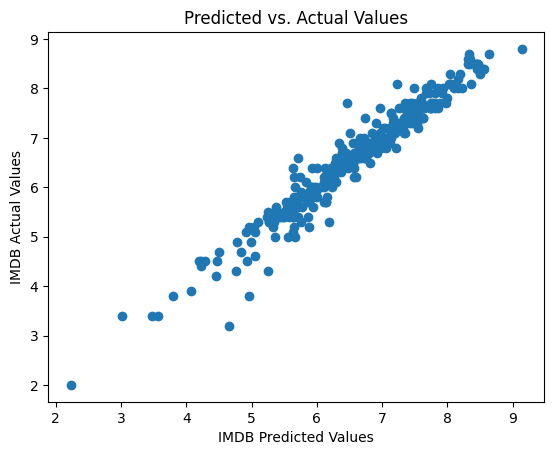

In [48]:
import matplotlib.pyplot as plt

# Assuming 'lr_model' is your best performing trained linear regression model
plt.scatter(lr_y_predict, y_test)  # y is your actual target values
plt.xlabel("IMDB Predicted Values")
plt.ylabel("IMDB Actual Values")
plt.title("Predicted vs. Actual Values")
plt.show()

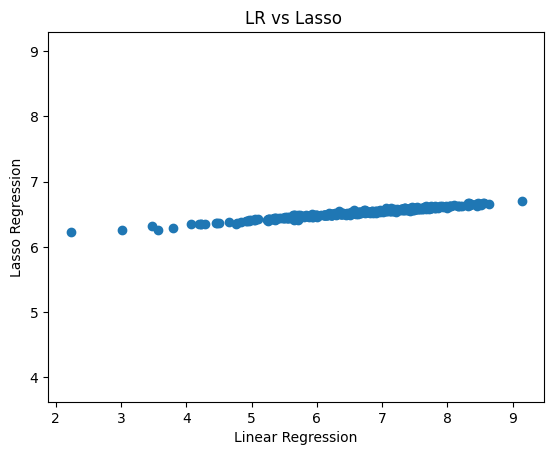

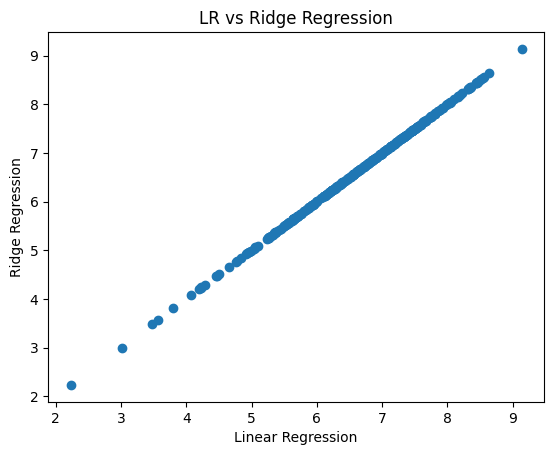

In [49]:
# Assuming 'lr_model' is your best performing trained linear regression model
lr_y_predict = lr_model.predict(X_test)  # X is your feature data
plt.scatter(lr_y_predict, Lasso_y_predict)  # y is your actual target values
plt.xlabel("Linear Regression")
plt.ylabel("Lasso Regression")
plt.axis('equal')
plt.title("LR vs Lasso ")
plt.show()
plt.scatter(lr_y_predict, Ridge_y_predict)  # y is your actual target values
plt.xlabel("Linear Regression")
plt.ylabel("Ridge Regression")
plt.title("LR vs Ridge Regression")
plt.show()

In [39]:
print("Mean: ",lr_y_predict.mean())

Mean:  6.56558120241583


In [40]:
median = np.median(lr_y_predict)
median
print("Median: ",median)

Median:  6.618729009835002


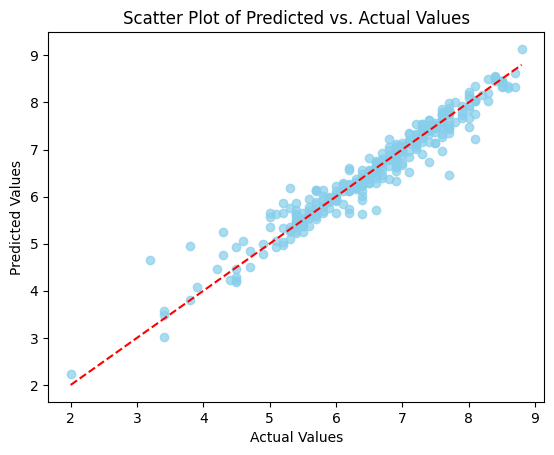

In [41]:


plt.scatter(y_test, lr_y_predict, color='skyblue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs. Actual Values')
plt.show()